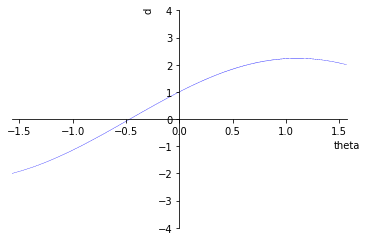

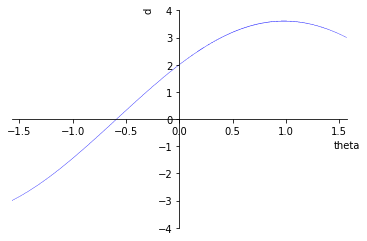

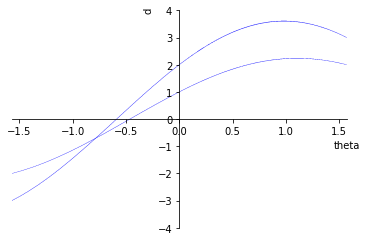

[{d: -sqrt(2)/2, theta: -pi/4}, {d: sqrt(2)/2, theta: 3*pi/4}]


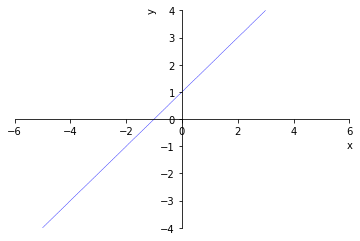

In [99]:
import sympy

d = sympy.Symbol('d')
theta = sympy.Symbol('theta')
x1,y1 = 1,2
x2,y2 = 2,3
curve1 = sympy.plot_implicit(sympy.Eq(x1*sympy.cos(theta) + y1*sympy.sin(theta), d), (theta, -sympy.pi/2, sympy.pi/2), (d, -4, 4))
curve2 = sympy.plot_implicit(sympy.Eq(x2*sympy.cos(theta) + y2*sympy.sin(theta), d), (theta, -sympy.pi/2, sympy.pi/2), (d, -4, 4))
curve1.extend(curve2)
curve1.show()

s = sympy.solve([sympy.Eq(x1*sympy.cos(theta) + y1*sympy.sin(theta), d), sympy.Eq(x2*sympy.cos(theta) + y2*sympy.sin(theta), d)])
print(s)
x = sympy.Symbol('x')
y = sympy.Symbol('y')
sympy.plot_implicit(sympy.Eq(x*sympy.cos(s[0][theta]) + y*sympy.sin(s[0][theta]), s[0][d]), (x,-6,6), (y,-4,4))

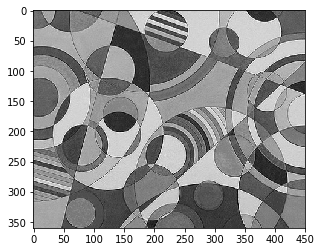

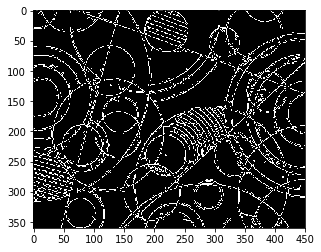

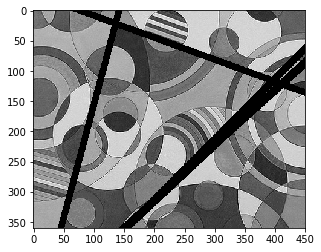

In [3]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

shapes = cv2.imread('images/shapes.png',0)
plt.imshow(shapes,'gray'); plt.show()

edges = cv2.Canny(shapes,50,150)
plt.imshow(edges,'gray'); plt.show()

# parâmetros: amostragem de d (1 pixel), amostragem de theta (1 grau), theshold p/ número de votos
lines = cv2.HoughLines(edges,1,np.pi/180,150)

for d,theta in np.squeeze(lines):
    cosseno, seno = np.cos(theta), np.sin(theta)
    x0,y0 = d*cosseno, d*seno
    delta = 1000 # maior que a diagonal (cruza toda a imagem)
    x1,y1 = int(x0 + delta*seno), int(y0 - delta*cosseno)
    x2,y2 = int(x0 - delta*seno), int(y0 + delta*cosseno)
    cv2.line(shapes,(x1,y1),(x2,y2),(0,0,0),10)
plt.imshow(shapes,'gray'); plt.show()

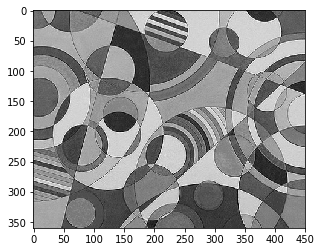

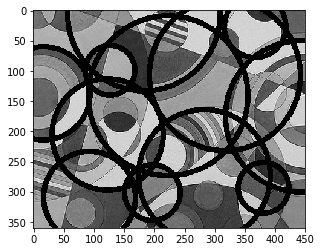

In [4]:
shapes = cv2.imread('images/shapes.png',0)
plt.imshow(shapes,'gray'); plt.show()

circles = cv2.HoughCircles(shapes, cv2.HOUGH_GRADIENT, dp=2, minDist=shapes.shape[0]/4, param1=150, param2=100)
# dp: amostragem / centro (2 pixels), minDist: menor raio, param1: threshold2 do Canny (o threshold1 vale a metade)
# param2: threshold p/ número de votos

for x,y,r in np.squeeze(circles):
    cv2.circle(shapes, (x,y), r, (0,0,0), 7)
plt.imshow(shapes,'gray'); plt.show()

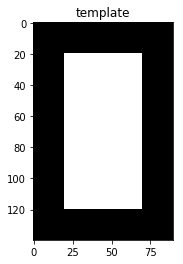

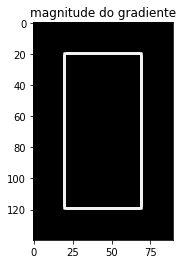

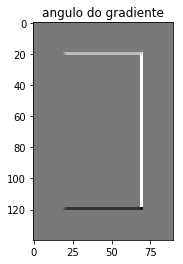

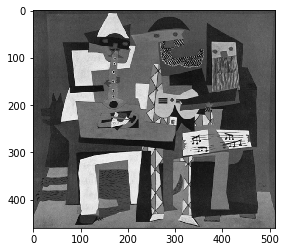

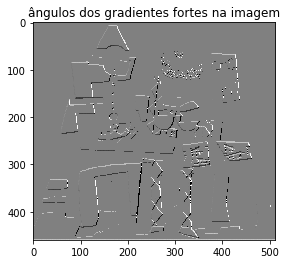

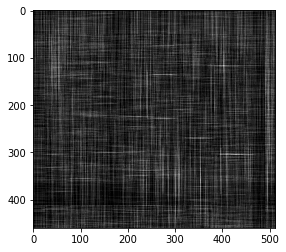

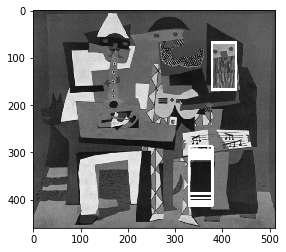

In [8]:
# Hough generalizado para localizar retângulos

rect_altura, rect_largura = 100, 50

template = cv2.copyMakeBorder(np.ones((rect_altura,rect_largura)), 20, 20, 20, 20, cv2.BORDER_CONSTANT)
plt.imshow(template,'gray'); plt.title('template'); plt.show()

### Treinamento ###

# gradientes
gx = cv2.Sobel(template, cv2.CV_64F, 1, 0)
gy = cv2.Sobel(template, cv2.CV_64F, 0, 1)
g = np.sqrt(gx**2 + gy**2)
plt.imshow(g,'gray'); plt.title('magnitude do gradiente'); plt.show()
theta = np.rint(np.arctan2(gy,gx) / (np.pi / 180)) # discretiza (1 grau)
plt.imshow(theta,'gray'); plt.title('angulo do gradiente'); plt.show()
g = g / np.max(g) # normaliza [0,1]

# cálculo dos displacements
center = np.array([template.shape[0]//2, template.shape[1]//2])
disp = {} # displacements: um par ordenado para cada (i,j)
for i in range(template.shape[0]):
    for j in range(template.shape[1]):
        if g[i,j] > 0.5: # edge point
            disp.setdefault(theta[i,j], []).append(center - np.array([i,j]))

### Detecção ###

img = cv2.imread('images/three-musicians.png',0)
plt.imshow(img,'gray'); plt.show()

# gradientes
gx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
gy = cv2.Sobel(img, cv2.CV_64F, 0, 1)
g = np.sqrt(gx**2 + gy**2) / np.max(g) # normaliza [0,1]
theta = np.rint(np.arctan2(gy,gx) / (np.pi / 180)) # discretiza (1 grau)

r,t = cv2.threshold(g, 0.3*np.max(g), 255, cv2.THRESH_BINARY)
plt.imshow(t*theta,'gray'); plt.title('ângulos dos gradientes fortes na imagem'); plt.show()

# contagem de votos
H = np.zeros(img.shape)
for i in range(img.shape[0]-rect_altura//2):
    for j in range(img.shape[1]-rect_largura//2):
        if g[i,j] > 0.5: # edge points
            for t in disp.setdefault(theta[i,j],[]):
                if i+t[0] < img.shape[0] and j+t[1] < img.shape[1]:
                    H[i+t[0],j+t[1]] += 1

plt.imshow(H,'gray'); plt.show()
max_cont = np.max(H)
for i in range(H.shape[0]):
    for j in range(H.shape[1]):
        if H[i,j] >= 0.9*max_cont:
            cv2.rectangle(img, (j-rect_largura//2,i-rect_altura//2), (j+rect_largura//2,i+rect_altura//2), (255,255,255), 4)
plt.imshow(img,'gray'); plt.show()